In [1]:
from phantominator import shepp_logan
from matplotlib import pyplot as plt

import torch

from loguru import logger
import pathlib
from natsort import natsorted, ns

from transformers import AutoModelForCausalLM

import csv

/home/nsagan/experiments/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### TODO
- Run on all layers of Mistral:
    - Compare LoftQ vs. Loftq-LPLR, alpha=0, same rank for both (use LoftQ default). Use 2, 4, 8 bits for the quantized part. Use 8 bits for LPLR factors.
    - Compare best fro errors (10 or 20 iters); 20ish+ iterations for LPLR
    - Save to CSV

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.insert(0, '../../src')
sys.path.insert(0,'../../peft/src')


from quantization import *
from weight_compressors import *
from hyperparameter_sweeps import *
from benchmarkers import *

from peft.utils.loftq_lplr_utils import loftq_lplr_init
from peft.utils.loftq_utils import loftq_init

In [4]:
DEFAULT_DEVICE = "cuda:2"

In [5]:
mistral = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-v0.1")

Loading checkpoint shards: 100%|██████████| 2/2 [00:22<00:00, 11.47s/it]


In [6]:
layer_name, X_mis = list(mistral.named_parameters())[4]
X_mis = X_mis.detach().to(DEFAULT_DEVICE)

torch.Size([4096, 4096])


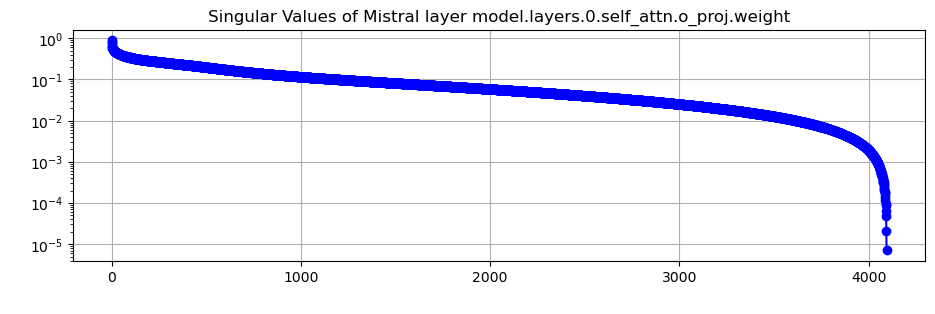

In [8]:
print(X_mis.shape)
_, S, _ = torch.linalg.svd(X_mis.float(), full_matrices=False)

# Plot the singular values
plt.figure(figsize=(11, 3))
plt.plot(S.cpu(), marker='o', linestyle='-', color='b')
plt.title(f'Singular Values of Mistral layer {layer_name}')
plt.xlabel('Index', color="white")
plt.ylabel('Singular Value', color="white")
plt.yscale('log')
plt.grid(True)
plt.show()

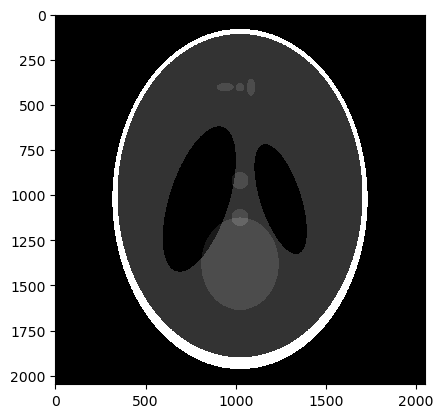

In [9]:
# Generate a phantominator matrix
X = torch.Tensor(shepp_logan(2048))
plt.imshow(X, cmap="gray", interpolation="nearest")
plt.show()

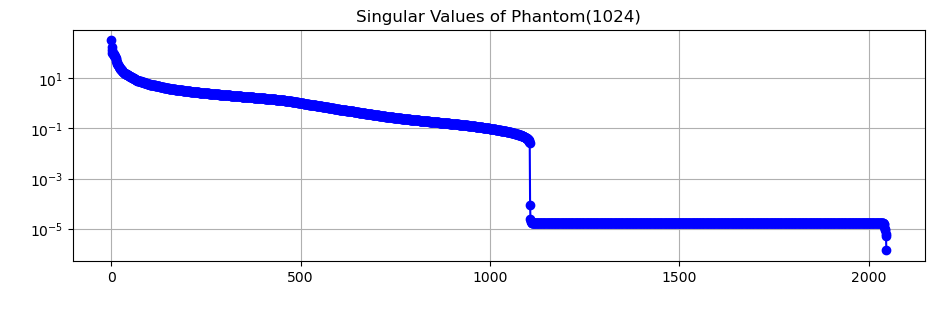

In [10]:
_, S, _ = torch.linalg.svd(X.float(), full_matrices=False)

# Plot the singular values
plt.figure(figsize=(11, 3))
plt.plot(S, marker='o', linestyle='-', color='b')
plt.title('Singular Values of Phantom(1024)')
plt.xlabel('Index', color="white")
plt.ylabel('Singular Value', color="white")
plt.yscale('log')
plt.grid(True)
plt.show()

In [11]:
def test_iterative_weight_compression(
    X = None,
    algorithm_kwargs = [{
        "k": 64, "r1": 0, "r2": 0,
        "B1": 8, "B2": 8
    }], # list of dictionaries
    algorithm_types = [AlgorithmType.ALTERNATING_MIXED_LPLR],
    plot_title = "Frobenius Norm Errors over Iterations"
):
    plot_colors = ["b", "r", "g", "c", "m", "k"]
    plot_markers = ["o", "X", "*"]
    # Set random seed for reproducibility
    torch.manual_seed(42)

    plt.figure(figsize=(11, 3))
    for i, param_set in enumerate(algorithm_kwargs):
        kwargs = param_set.copy()
        kwargs["log_errors"] = True

        if algorithm_types[i] == AlgorithmType.ALTERNATING_MIXED_LPLR:
            kwargs["X"] = X
            _, _, errors = alternating_mixed_lplr(**kwargs)
        elif algorithm_types[i] == AlgorithmType.DIRECT_SVD_LPLR:
            kwargs["X"] = X
            _, _, errors = direct_svd_mixed_lplr(**kwargs)
        elif algorithm_types[i] == AlgorithmType.LOFTQ:
            kwargs["weight"] = X
            _, _, _, errors = loftq_init(**kwargs)
        else: ## Loftq-LPLR
            kwargs["weight"] = X
            _, _, _, errors = loftq_lplr_init(**kwargs)

        fro_norm_X = torch.norm(X, p="fro").item()
        relative_errors = np.array(errors) / fro_norm_X

        # Plot errors over iterations
        plt.plot(
            range(1, len(relative_errors) + 1),
            relative_errors,
            marker=plot_markers[(i // len(plot_colors)) % len(plot_markers)],
            linestyle="-",
            markersize=4,
            color=plot_colors[i % len(plot_colors)],
            label=f"Param Set {i+1}*")

    print("-"*80, "\n* Legend Key")
    for i, kwargs in enumerate(algorithm_kwargs):
        print(f"Param Set {i+1}: ", kwargs)
        print("\tusing algorithm type ", algorithm_types[i])

    plt.title(plot_title)
    plt.xlabel("Iteration")
    plt.ylabel("Error")
    plt.yscale("log")
    plt.grid(True)
    plt.legend()
    plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [01:16<00:00,  3.83s/it]


-------------------------------------------------------------------------------- 
* Legend Key
Param Set 1:  {'num_bits': 4, 'reduced_rank': 64, 'num_iter': 20}
	using algorithm type  AlgorithmType.LOFTQ
Param Set 2:  {'num_bits': 4, 'num_bits_factors': 8, 'reduced_rank': 64, 'num_iter': 20, 'num_iter_lplr': 40}
	using algorithm type  AlgorithmType.LOFTQ_LPLR


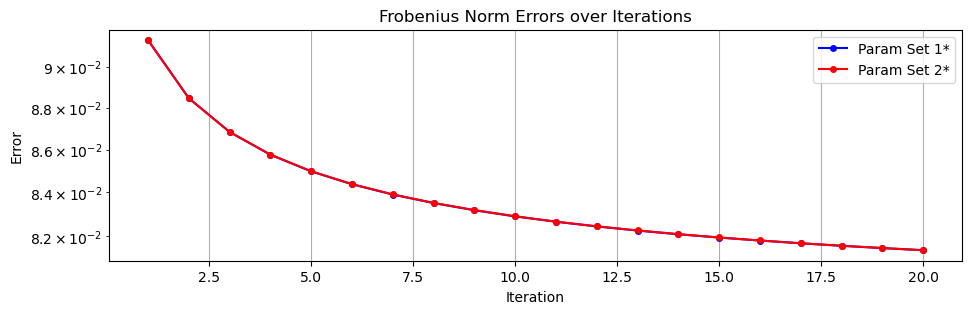

In [22]:
test_iterative_weight_compression(
    algorithm_kwargs = [{
        "num_bits": 4, "reduced_rank": 64, "num_iter": 20
    },
    {
        "num_bits": 4, "num_bits_factors": 8, "reduced_rank": 64,
        "num_iter": 20, "num_iter_lplr": 40
    }],
    algorithm_types=[
        AlgorithmType.LOFTQ, AlgorithmType.LOFTQ_LPLR
    ],
    plot_title="Frobenius Norm Errors over Iterations",
    X=X_mis.T
)

In [13]:
### Do some hyperparameter sweeps on the Shepp-Logan matrix
average_bit_level = 3
budget = X.shape[0] * X.shape[1] * average_bit_level

In [24]:
mtxs, alpha, beta, B, error = lplr_sweep_alpha_and_B(
    X=X, budget=budget,
    kwarg_dict={"quant_type": QuantType.NF, "iters":30},
    lplr_type=AlgorithmType.ALTERNATING_MIXED_LPLR,
    debug=True
)

--------------------------------------------------


2024-01-10 18:40:08.805 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:138 - B1=4, B2=4, alpha=0.0, beta=0.375
2024-01-10 18:40:15.457 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:153 - Frobenius norm error: 0.05451740576937921


--------------------------------------------------


2024-01-10 18:40:15.459 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:138 - B1=4, B2=4, alpha=0.1, beta=0.28846154
2024-01-10 18:40:20.730 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:153 - Frobenius norm error: 0.017954548469732347


--------------------------------------------------


2024-01-10 18:40:20.731 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:138 - B1=4, B2=4, alpha=0.2, beta=0.234375
2024-01-10 18:40:24.906 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:153 - Frobenius norm error: 0.024087574294205053


--------------------------------------------------


2024-01-10 18:40:24.907 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:138 - B1=4, B2=4, alpha=0.3, beta=0.19736842
2024-01-10 18:40:28.442 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:153 - Frobenius norm error: 0.033783322337951796


--------------------------------------------------


2024-01-10 18:40:28.443 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:138 - B1=4, B2=4, alpha=0.4, beta=0.17045455
2024-01-10 18:40:31.793 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:153 - Frobenius norm error: 0.041931280724754445


--------------------------------------------------


2024-01-10 18:40:31.794 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:138 - B1=4, B2=4, alpha=0.5, beta=0.15
2024-01-10 18:40:34.628 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:153 - Frobenius norm error: 0.048847761404642906


--------------------------------------------------


2024-01-10 18:40:34.629 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:166 - [B1=4, B2=4]The best frobenius norm error was for alpha=0.1: 0.017954548469732347


--------------------------------------------------


2024-01-10 18:40:34.630 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:138 - B1=8, B2=8, alpha=0.0, beta=0.1875
2024-01-10 18:40:47.614 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:153 - Frobenius norm error: 0.05454671338598251


--------------------------------------------------


2024-01-10 18:40:47.615 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:138 - B1=8, B2=8, alpha=0.1, beta=0.17045455
2024-01-10 18:40:59.259 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:153 - Frobenius norm error: 0.04115327205066479


--------------------------------------------------


2024-01-10 18:40:59.260 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:138 - B1=8, B2=8, alpha=0.2, beta=0.15625
2024-01-10 18:41:09.007 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:153 - Frobenius norm error: 0.046144552130169235


--------------------------------------------------


2024-01-10 18:41:09.008 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:138 - B1=8, B2=8, alpha=0.3, beta=0.14423077
2024-01-10 18:41:17.475 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:153 - Frobenius norm error: 0.05050674361624631


--------------------------------------------------


2024-01-10 18:41:17.476 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:138 - B1=8, B2=8, alpha=0.4, beta=0.13392857
2024-01-10 18:41:24.777 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:153 - Frobenius norm error: 0.054503388919308775


--------------------------------------------------


2024-01-10 18:41:24.778 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:138 - B1=8, B2=8, alpha=0.5, beta=0.125
2024-01-10 18:41:30.515 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:153 - Frobenius norm error: 0.0581346161847996


--------------------------------------------------


2024-01-10 18:41:30.516 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:166 - [B1=8, B2=8]The best frobenius norm error was for alpha=0.1: 0.04115327205066479


--------------------------------------------------


2024-01-10 18:41:30.517 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha_and_B:234 - The best frobenius norm error was for B=4, alpha=0.1: 0.017954548469732347


In [16]:
mtxs, alpha, beta, B, error = lplr_sweep_alpha_and_B(
    X=X, budget=budget,
    kwarg_dict={"quant_type": QuantType.NF, "num_bits": 2, "num_iter": 20, "num_iter_lplr": 20},
    lplr_type=AlgorithmType.LOFTQ_LPLR,
    debug=True
)

--------------------------------------------------


2024-01-10 18:54:51.132 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:143 - B=4, alpha=0.0, beta=0.125
  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:51<00:00,  2.58s/it]
2024-01-10 18:55:42.690 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:159 - Frobenius norm error: 0.009047840915121282


--------------------------------------------------


2024-01-10 18:55:42.696 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:143 - B=4, alpha=0.1, beta=0.09615385
  5%|▌         | 1/20 [02:07<40:20, 127.40s/it]


In [2]:
class BenchmarkerComparison():
    def __init__(
        self,
        benchmarkers: list[WeightCompressionBenchmarker] = [],
        enforce_budget = True,
        average_bit_level = 4,
        save_to_csv = False,
        save_file = None,
        reset_error_lists = True
    ):
        if reset_error_lists:
            for benchmarker in benchmarkers:
                benchmarker.reset_errors()

        self.benchmarkers = benchmarkers
        self.save_to_csv = save_to_csv
        self.save_file = save_file
        self.enforce_budget = enforce_budget
        self.average_bit_level = average_bit_level if enforce_budget else 16
        
        if save_to_csv:
            with open(save_file, 'w') as csvfile:
                writer = csv.writer(csvfile)

                first_headers = ["Layer Name", "n", "d"]
                if enforce_budget:
                    first_headers.append("Bit Budget")
                writer.writerow(first_headers + [benchmarker.label for bechmarker in benchmarkers])
    
    def write_latest_data(self, layer_name, n, d, budget=0):
        with open(self.save_file, 'a') as csvfile:
            writer = csv.writer(csvfile)
            first_items = [layer_name, n, d]
            if self.enforce_budget:
                first_items.append(budget)
            writer.writerow(first_items + [benchmarker.errors[-1] for benchmarker in self.benchmarkers])
    
    def run_on_matrix(self, layer_name, X):
        print(f"Benchmarking {layer_name}")
        n, d = X.size()
        budget = n*d*average_bit_level

        for benchmarker in self.benchmarkers:
            benchmarker.run(X, budget)

        if self.save_to_csv:
            self.write_latest_data(layer_name, n, d, budget)

    def print_errors(self):
        for benchmarker in self.benchmarkers:
            print(f"{benchmarker.label}: {benchmarker.errors}")

    def plot_errors(self):
        plot_colors = ["b", "r", "g", "c", "m", "k"]
        plot_markers = ["o", "X", "*"]

        plt.figure(15, 4)
        for i, benchmarker in enumerate(self.benchmarkers):
            plt.plot(
                benchmarker.errors,
                marker=plot_markers[(i // len(plot_colors)) % len(plot_markers)],
                linestyle="-",
                markersize=4,
                color=plot_colors[i % len(plot_colors)],
                label=benchmarker.label
            )
        plt.title("Relative Frobenius Error")
        plt.xlabel("Layer")
        plt.ylabel("Error")
        plt.yscale("log")
        plt.grid(True)
        plt.legend()
        plt.show()


In [3]:
class BenchmarkerComparisonList(BenchmarkerComparison):
    def __init__(
        self,
        X_list: list[torch.Tensor] = [],
        **kwargs
    ):
        self.X_list = X_list
        super().__init__(**kwargs)

    def run(self):
        for i, X in enumerate(self.X_list):
            self.run_on_matrix(f"Matrix {i}", X)

NameError: name 'torch' is not defined

In [ ]:
class BenchmarkerComparisonModel(BenchmarkerComparison):
    def __init__(
        self,
        model,
        device = "cpu",
        layer_limit:int = -1, # Limits the number of weight matrices used
                              # for benchmarking (mainly for debugging purposes).
                              # -1 means no limit.
         max_num_cols:int = -1, # Excludes weight matrices that are too large.
        **kwargs
    ):
        self.model = model
        self.device = device
        self.layer_limit = layer_limit if layer_limit > 0 else float('inf')
        self.max_num_cols = max_num_cols if max_num_cols > 0 else float('inf')
        super().__init__(**kwargs)

    def run(self):
        layer_count = 0
        for layer_name, X in self.model.named_parameters():
            if X.dim() != 2:
                continue
            if X.shape[0] < X.shape[1]:
                X = X.T
            if X.shape[0] > self.max_num_cols:
                logger.info("Layer larger than maximum size specified, skipping.")
                break

            layer_count += 1
            if layer_count > self.layer_limit:
                logger.info("Reached layer limit, exiting.")
                return layer_count
            
            self.run_on_matrix(layer_name, X.float().to(self.device))
            

In [10]:
benchmarkers = [
        LoftqBenchmarker(
            {
                "quant_type": QuantType.NF,
                "num_iter": 30,
                "reduced_rank": 64,
                "num_bits": 2,
            },
            label="LoftQ (2B)"
        ),
        LoftqBenchmarker(
            {
                "quant_type": QuantType.NF,
                "num_iter": 30,
                "reduced_rank": 64,
                "num_bits": 4,
            },
            label="LoftQ (4B)"
        ),
        LoftqBenchmarker(
            {
                "quant_type": QuantType.NF,
                "num_iter": 30,
                "reduced_rank": 64,
                "num_bits": 8,
            },
            label="LoftQ (8B)"
        ),
        LplrBenchmarker(
            AlgorithmType.LOFTQ_LPLR,
            {
                "quant_type": QuantType.NF,
                "num_bits": 2,
                "num_bits_factors": 8,
                "reduced_rank": 64
            },
            label="Loftq-LPLR (2B)",
            run_hyper_parameter_sweep=False
        ),
        LplrBenchmarker(
            AlgorithmType.LOFTQ_LPLR,
            {
                "quant_type": QuantType.NF,
                "num_bits": 4,
                "num_bits_factors": 8,
                "reduced_rank": 64
            },
            label="Loftq-LPLR (4B)",
            run_hyper_parameter_sweep=False
        ),
        LplrBenchmarker(
            AlgorithmType.LOFTQ_LPLR,
            {
                "quant_type": QuantType.NF,
                "num_bits": 8,
                "num_bits_factors": 8,
                "reduced_rank": 64
            },
            label="Loftq-LPLR (8B)",
            run_hyper_parameter_sweep=False
        )
    ]

In [ ]:
## For debugging, we set limits on how many layers we use
## and their sizes
comparison_object = BenchmarkerComparisonModel(
    model=mistral,
    device=DEFAULT_DEVICE,
    layer_limit=5,
    max_num_cols=15000,
    benchmarkers=benchmarkers,
    enforce_budget=False,
    save_as_csv=True,
    save_file="/home/nsagan/experiments/results/Loftq_LPLR_comparsion.csv"
)

In [ ]:
comparison_object.run()

In [ ]:
comparison_object.print_errors()

In [ ]:
comparison_object.plot_errors()